In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('data/ner_dataset.csv', encoding='latin1')
data = data.fillna(method='ffill')

In [2]:
class SentenceGetter:
    def __init__(self, data):
        self.pos = 1
        self.data = data
        self.empty = False
        
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s.Word.tolist(),
                                                          s.POS.tolist(),
                                                          s.Tag.tolist())]
        
        self.grouped = self.data.groupby('Sentence #').apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def reset(self):
        self.pos = 1
        
    def get_next(self):
        try:
            s = self.grouped['Sentence: {}'.format(self.pos)]
            self.pos += 1
            return s
        except:
            return None

In [3]:
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [8]:
words = set(data.Word.tolist())
PADDING = 'PADDING'
words.add(PADDING)
n_words = len(words)

tags = set(data.Tag.tolist())
n_tags = len(tags)

print('words: {n_words} tags: {n_tags}'.format(n_words=n_words, n_tags=n_tags))

words: 35179 tags: 17


In [10]:
getter = SentenceGetter(data)

In [23]:
sentences = getter.sentences
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

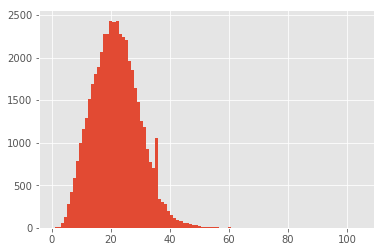

In [14]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.hist([len(s) for s in sentences], bins=100)
plt.show()

In [15]:
max_len = 50
word2idx = {w:i for i, w in enumerate(words)}
tag2idx = {t:i for i, t in enumerate(tags)}

In [17]:
print(word2idx['Obama'])
print(tag2idx['B-geo'])

11577
7


In [19]:
from keras.preprocessing.sequence import pad_sequences

In [20]:
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding='post', value=n_words-1)

In [22]:
X[0]

array([ 2179,  9615, 18068, 13530, 31943, 22174, 34517, 31710, 34592,
         882, 11713,  4020, 28064,   640, 22464,   882,  7593,  9615,
        2693, 12650, 29102, 32552, 28135, 13291, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178], dtype=int32)

In [26]:
y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding='post', value=tag2idx['O'])
y[0]

array([8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 4, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8], dtype=int32)

In [28]:
from keras.utils import to_categorical

In [29]:
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [31]:
from sklearn.model_selection import train_test_split

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [42]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
import keras_metrics

In [45]:
input = Input(shape=(max_len,), name='input_layer')
embedding = Embedding(input_dim=n_words, output_dim=50, input_length=max_len, name='word_embedding')(input)
dropout = Dropout(0.1, name='dropout')(embedding)
blstm = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1, name='bi_lstm'))(dropout)
output = TimeDistributed(Dense(n_tags, activation='softmax', name='output'))(blstm)

In [46]:
model = Model(inputs=[input], outputs=output)

In [50]:
model.compile(optimizer="rmsprop", 
              loss="categorical_crossentropy", 
              metrics=["accuracy"])

In [73]:
history = model.fit(X_train, 
                    np.array(y_train), 
                    batch_size=128, 
                    epochs=5, 
                    validation_split=0.1,
                    verbose=1)

Train on 38846 samples, validate on 4317 samples
Epoch 1/5
38846/38846 [==============================] - 58s 1ms/step - loss: 0.0810 - acc: 0.9772 - val_loss: 0.0590 - val_acc: 0.9828
Epoch 2/5
38846/38846 [==============================] - 58s 1ms/step - loss: 0.0522 - acc: 0.9847 - val_loss: 0.0520 - val_acc: 0.9847
Epoch 3/5
38846/38846 [==============================] - 57s 1ms/step - loss: 0.0441 - acc: 0.9870 - val_loss: 0.0467 - val_acc: 0.9862
Epoch 4/5
38846/38846 [==============================] - 57s 1ms/step - loss: 0.0398 - acc: 0.9881 - val_loss: 0.0465 - val_acc: 0.9856
Epoch 5/5
38846/38846 [==============================] - 57s 1ms/step - loss: 0.0368 - acc: 0.9890 - val_loss: 0.0433 - val_acc: 0.9870


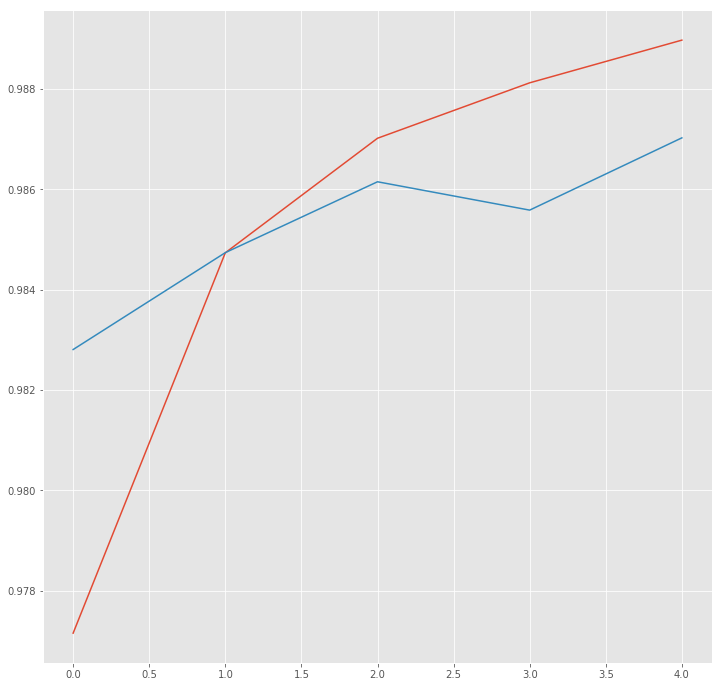

In [74]:
history_df = pd.DataFrame(history.history)

plt.figure(figsize=(12,12))
plt.plot(history_df['acc'])
plt.plot(history_df['val_acc'])
plt.show()

In [75]:
from sklearn_crfsuite.metrics import flat_classification_report

In [76]:
y_pred = model.predict(X_test, verbose=True)

4796/4796 [==============================] - 2s 481us/step


In [77]:
idx2tag = {i:w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace('PAD', 'O'))
        out.append(out_i)
    return out

pred_label = pred2label(y_pred)
test_label = pred2label(y_test)

In [78]:
print(flat_classification_report(pred_label, test_label))

             precision    recall  f1-score   support

      B-art       0.00      0.00      0.00         0
      B-eve       0.23      0.80      0.36        10
      B-geo       0.89      0.86      0.88      3825
      B-gpe       0.94      0.96      0.95      1444
      B-nat       0.00      0.00      0.00         0
      B-org       0.72      0.80      0.75      1770
      B-per       0.83      0.85      0.84      1746
      B-tim       0.89      0.93      0.91      1929
      I-art       0.00      0.00      0.00         0
      I-eve       0.00      0.00      0.00         0
      I-geo       0.79      0.83      0.81       707
      I-gpe       0.69      1.00      0.82         9
      I-nat       0.00      0.00      0.00         0
      I-org       0.76      0.80      0.78      1526
      I-per       0.91      0.84      0.88      1899
      I-tim       0.75      0.84      0.79       546
          O       1.00      1.00      1.00    224389

avg / total       0.99      0.99      0.99  

/Users/kyouyeolhan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
